In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import h5py
import os
import time
import pickle
from sklearn.linear_model import LinearRegression

import scanpy.api as sc
import sceb.data_loader as dl 
import sceb.scdd as sd

%matplotlib inline
%load_ext autoreload
%autoreload 2

from matplotlib import rcParams

params = {
   'axes.labelsize': 16,
   'font.size': 16,
   'legend.fontsize': 10,
   'xtick.labelsize': 13,
   'ytick.labelsize': 13,
   'text.usetex': False,
   'text.usetex': False,
   }
rcParams.update(params)

/home/martin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
output_folder = '/home/martin/single_cell_eb/figures/figure_schema'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Basic quantities of the datasets

In [5]:
## Collect the data
dataset={}
dataset['brain_1k'] = dl.load_10x_1k() # 1k brain cells 
dataset['brain_2k'] = dl.load_10x_2k() # 2k brain cells 
dataset['brain_9k'] = dl.load_10x_9k() # 9k brain cells 
dataset['brain_1.3m'] = dl.load_10x_1_3mil() # 1.3 million brain cells 
dataset['pbmc_4k'] = dl.load_10x_4k() # 4k PBMC cells
dataset['pbmc_8k'] = dl.load_10x_8k() # 8k PBMC cells 
dataset['3T3_12k'] = dl.load_10x_12k_mix_mouse() # 12k cells 
dataset['3T3_6k'] = dl.load_10x_6k_mix_mouse() # 6k cells
dataset['3T3_1k'] = dl.load_10x_1k_mix_mouse() # 6k cells
dataset['293T_12k'] = dl.load_10x_12k_mix_human() # 12k cells 
dataset['293T_6k'] = dl.load_10x_6k_mix_human() # 6k cells
dataset['293T_1k'] = dl.load_10x_1k_mix_human() # 6k cells

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [6]:
gene_param_dic = {}
for key in dataset.keys():
#     if key == 'brain_1.3m':
#         continue
    
    gene_param_dic[key] = {}
    Nc,G,Nr,Nr_bar = sd.get_info(dataset[key])
    M_ml,M_dd = sd.dd_1d_moment(dataset[key],size_factor=None,verbose=False)
    mean_count = M_ml[0]
    var_count = M_ml[1] - M_ml[0]**2
    gamma_param = sd.M_to_gamma(M_dd)
    
    gene_param_dic[key]['gene_list'] = np.array(dataset[key].var_names)
    gene_param_dic[key]['M_dd'] = M_dd
    gene_param_dic[key]['M_ml'] = M_ml
    gene_param_dic[key]['mean_count'] = mean_count
    gene_param_dic[key]['var_count'] = var_count
    gene_param_dic[key]['gamma_param'] = gamma_param
    gene_param_dic[key]['data_param'] = [Nc,G,Nr,Nr_bar]
       
fname = output_folder+'/gene_param_dic.pickle'
f_myfile = open(fname,'wb')
pickle.dump(gene_param_dic, f_myfile)
f_myfile.close()    


## Nc=931, G=27998, Nr=11531.54, Nr_bar=0.41
## Nc=2022, G=27998, Nr=7590.87, Nr_bar=0.27


/home/martin/single_cell_eb/scdd.py:1199: RuntimeWarning: invalid value encountered in true_divide
  gamma_param[0] = (M[1]/M[0]-M[0]).clip(min=0)
/home/martin/single_cell_eb/scdd.py:1200: RuntimeWarning: invalid value encountered in true_divide
  gamma_param[1] = (M[0]**2/(M[1]-M[0]**2)).clip(min=0,max=10)


## Nc=9128, G=27998, Nr=7346.04, Nr_bar=0.26
## Nc=1306127, G=27998, Nr=4891.33, Nr_bar=0.17
## Nc=4340, G=33694, Nr=4349.04, Nr_bar=0.13
## Nc=8381, G=33694, Nr=4639.05, Nr_bar=0.14
## Nc=6657, G=27998, Nr=11041.74, Nr_bar=0.39
## Nc=3427, G=27998, Nr=20132.37, Nr_bar=0.72
## Nc=516, G=27998, Nr=23030.19, Nr_bar=0.82
## Nc=6893, G=32738, Nr=18466.26, Nr_bar=0.56
## Nc=3550, G=32738, Nr=31499.95, Nr_bar=0.96
## Nc=504, G=32738, Nr=35653.05, Nr_bar=1.09


# What are the r and theta's ? 

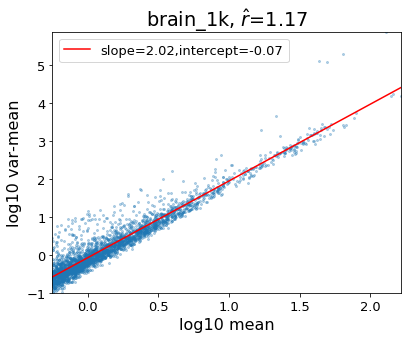

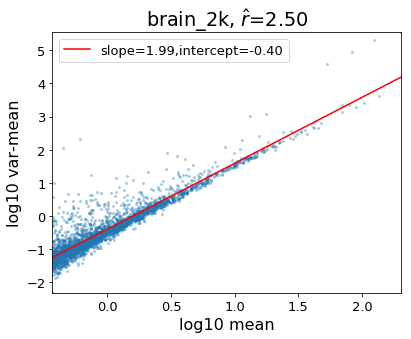

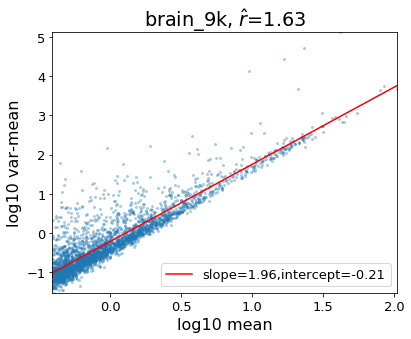

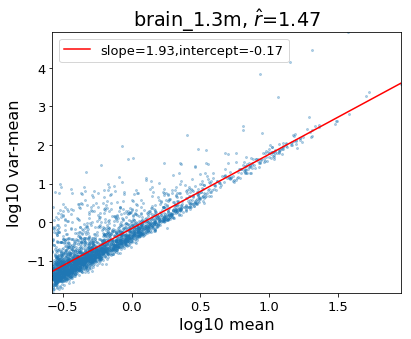

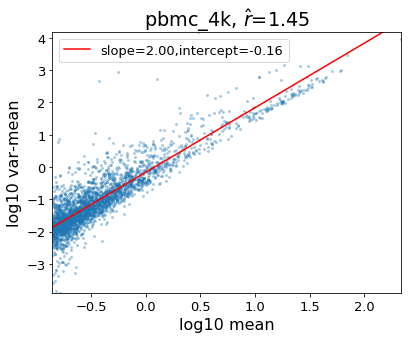

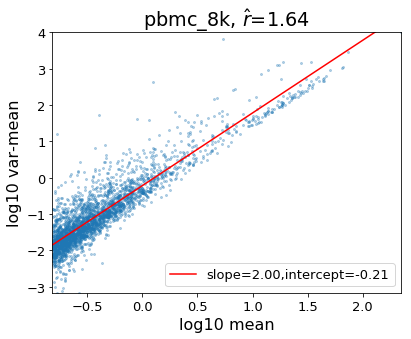

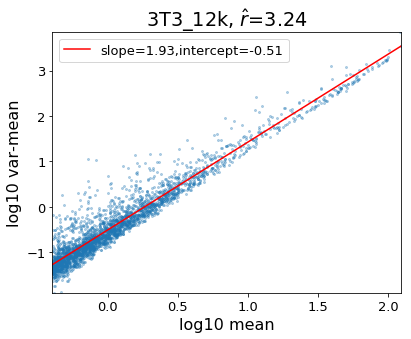

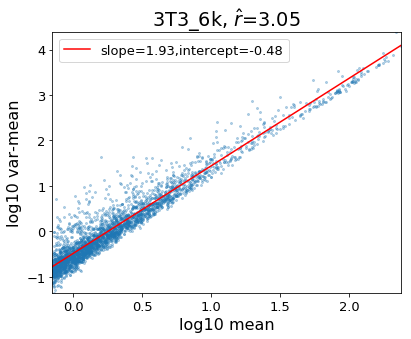

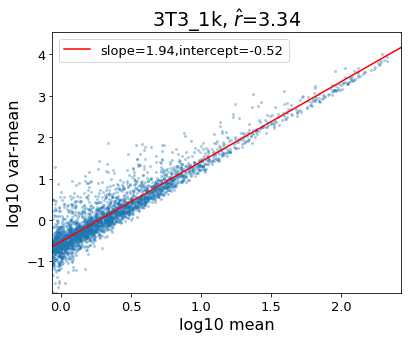

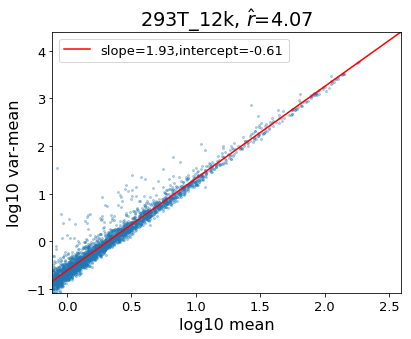

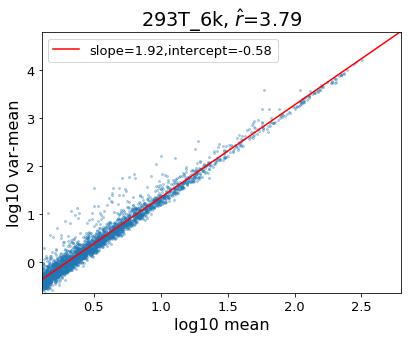

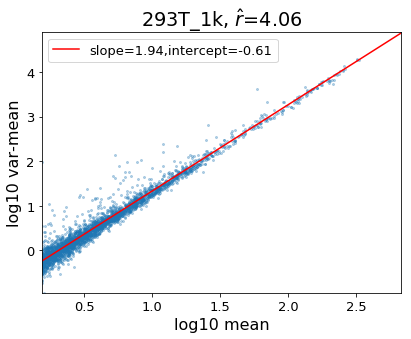

In [3]:
n_top_gene = 3000

## Figure generation
fname = output_folder+'/gene_param_dic.pickle'
f_myfile = open(fname, 'rb')
gene_param_dic = pickle.load(f_myfile)
f_myfile.close()

for key in gene_param_dic.keys():
    mean_count = gene_param_dic[key]['mean_count']
    var_count = gene_param_dic[key]['var_count']
    sort_idx = np.argsort(mean_count)[::-1]
    dif_var_mean_ml = var_count - mean_count
    
    ## Linear regression to determine r
    LR = LinearRegression()
    x = np.log10(mean_count[sort_idx[0:n_top_gene]].clip(min=1e-6))
    y = np.log10(dif_var_mean_ml[sort_idx[0:n_top_gene]].clip(min=1e-6))
    idx_select = (y>-6)*(x>-6)
    x = x[idx_select].reshape([-1,1])
    y = y[idx_select]
    LR.fit(x,y)
    a,b = LR.coef_,LR.intercept_
    r_hat = 10**(-b)
    
    plt.figure(figsize=[6,5])
    plt.scatter(x,y,alpha=0.3,s=4)
    
    x_min = np.min(x)
    x_max = np.max(x)
    y_min = np.min(y)
    y_max = np.max(y)
    
    plt.plot([x_min,x_max],[a*x_min+b,a*x_max+b],color='r',label='slope=%0.2f,intercept=%0.2f'%(a,b))
    plt.xlim([x_min,x_max])
    plt.ylim([y_min,y_max])
    plt.xlabel('log10 mean')
    plt.ylabel('log10 var-mean')
    plt.title(key+', $\hat{r}$=%0.2f'%r_hat)
    plt.legend(fontsize=13)
    plt.tight_layout()
    plt.savefig(output_folder+'/r_regression_%s.png'%key)
    plt.savefig(output_folder+'/r_regression_%s.pdf'%key)
    plt.show()

# dataset parameter plot

brain_1k 931
brain_2k 2022
brain_9k 9128
brain_1.3m 1306127
pbmc_4k 4340
pbmc_8k 8381
3T3_12k 6657
3T3_6k 3427
3T3_1k 516
293T_12k 6893
293T_6k 3550
293T_1k 504


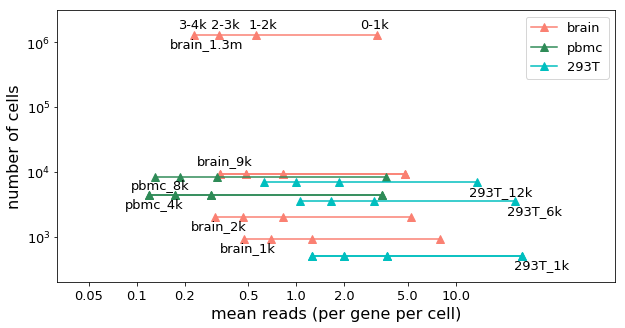

In [3]:
## Figure generation
fname = output_folder+'/gene_param_dic.pickle'
f_myfile = open(fname, 'rb')
gene_param_dic = pickle.load(f_myfile)
f_myfile.close()

## Generate the subsample parameter figure 
plt.figure(figsize=[10,5])
    
for key in gene_param_dic.keys():
#     if 'hek' in key:
#         continue
    
    mean_count = gene_param_dic[key]['mean_count']    
    fp = np.log10(sd.get_fingerprint(mean_count))
    Nc,G,Nr,Nr_bar = gene_param_dic[key]['data_param']
    print(key,Nc)
    
    if 'pbmc' in key:
        plt.plot(fp,np.log10(Nc)*np.ones(fp.shape[0]),marker='^',color='seagreen',zorder=10,ms=8)
        if '4k' in key:
            plt.plot(fp,np.log10(Nc)*np.ones(fp.shape[0]),marker='^',color='seagreen',zorder=10,ms=8,label='pbmc')

        plt.annotate(key,[fp[3]-0.15,np.log10(Nc)-0.2],fontsize=13,zorder=10)
        
    elif 'brain' in key:
        plt.plot(fp,np.log10(Nc)*np.ones(fp.shape[0]),marker='^',color='salmon',zorder=10,ms=8)
        if '9k' in key:
            plt.plot(fp,np.log10(Nc)*np.ones(fp.shape[0]),marker='^',color='salmon',zorder=10,ms=8,label='brain')
            
        if '9k' in key:
            plt.annotate(key,[fp[3]-0.15,np.log10(Nc)+0.15],fontsize=13,zorder=10)
        else:
            plt.annotate(key,[fp[3]-0.15,np.log10(Nc)-0.2],fontsize=13,zorder=10)
        
    elif '293T' in key:
        plt.plot(fp,np.log10(Nc)*np.ones(fp.shape[0]),marker='^',color='c',zorder=10,ms=8)
        if '1k' in key:
            plt.plot(fp,np.log10(Nc)*np.ones(fp.shape[0]),marker='^',color='c',zorder=10,ms=8,label='293T')
        plt.annotate(key,[fp[0]-0.05,np.log10(Nc)-0.2],fontsize=13,zorder=10)
        
#     elif 'nih' in key:
#         plt.plot(fp,np.log10(Nc)*np.ones(fp.shape[0]),marker='^',color='darkgrey',zorder=10,ms=8)
#         if '1k' in key:
#             plt.plot(fp,np.log10(Nc)*np.ones(fp.shape[0]),marker='^',color='darkgrey',zorder=10,ms=8,label='nih')
#         plt.annotate(key,[fp[0]-0.15,np.log10(Nc)-0.2],fontsize=13,zorder=10)

    
#     if dname=='brain_9k':
#         plt.annotate(key,[fp[2],np.log10(Nc)+0.1],fontsize=13,zorder=10)
#     else:
#         plt.annotate(key,[fp[-1],np.log10(Nc)-0.2],fontsize=13,zorder=10)
    
    if key=='brain_1.3m':
        plt.annotate('0-1k',[fp[0]-0.1,np.log10(Nc)+0.1],fontsize=13)
        plt.annotate('1-2k',[fp[1]-0.05,np.log10(Nc)+0.1],fontsize=13)
        plt.annotate('2-3k',[fp[2]-0.05,np.log10(Nc)+0.1],fontsize=13)
        plt.annotate('3-4k',[fp[3]-0.1,np.log10(Nc)+0.1],fontsize=13)

#         plt.plot(fp,np.log10(Nc)*np.ones(fp.shape[0]),marker='^',color='green',zorder=10,ms=8,label='Dataset')

# plt.plot([np.log10(0.2),np.log10(0.2)],[1.8,6.7],color='red',ls='--',label='Reliable detection threshold')

plt.xlabel('mean reads (per gene per cell)')
plt.ylabel('number of cells')

Nr_bar_list = np.array([0.02,0.05,0.1,0.2,0.5,1,2,5,10])
plt.xticks(np.log10(Nr_bar_list),Nr_bar_list)
plt.yticks([3,4,5,6],['$10^3$','$10^4$','$10^5$','$10^6$'])
plt.ylim([2.3,6.5])
plt.xlim([-1.5,2])
# plt.title('Budget')
plt.legend(fontsize=13)
plt.savefig(output_folder+'/data_param.png')
plt.savefig(output_folder+'/data_param.pdf')
plt.show()

# gene relative abundence plot

In [69]:
def get_error_gamma(r,theta,Nr,Nc,c_gamma_1=1,c_gamma_2=1):
    error_theta = (2*r+3)*theta**2/r \
                 + (4*r+5)*theta/Nr/r*c_gamma_1 \
                 + 2*(r+1)/Nr**2/r*c_gamma_2
    error_theta /= Nc
    error_theta /= theta**2

    error_r = 2*r*(r+1) \
              + 4*r*(r+1)/theta/Nr*c_gamma_1 \
              + 2*r*(r+1)/Nr**2/theta**2*c_gamma_2
    error_r /= Nc
    error_r /= r**2
    return error_theta,error_r

def plot_relative_abundance(plot_list,gene_param_dic,marker_gene_list,gene_star,data_ref,suffix='',require_ref=True):
    n_top_gene = 8000
    color_list = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
    
    # find p_star 
    mean_count = gene_param_dic[data_ref]['mean_count']
    p_ = mean_count/mean_count.sum()
    gene_list = list(gene_param_dic[data_ref]['gene_list'])
    gene_star_idx = gene_list.index(gene_star)
    p_star = p_[gene_star_idx]
    
    # generate the figure
    plt.figure(figsize=[6,5])
#     plt.figure(figsize=[18,18])
    for i_key,key in enumerate(plot_list):
        # abundance plot
        mean_count = gene_param_dic[key]['mean_count']
        sort_idx = np.argsort(mean_count)[::-1]
        p_ = mean_count/mean_count.sum()
        
        if key == 'pbmc_8k' or key == '293T_6k' or key == '3T3_6k':
            plt.plot(np.log10(np.arange(n_top_gene)+1),np.log10(p_[sort_idx[0:n_top_gene]]),\
                     label=key,color=color_list[i_key],lw=3,ls='--')
            
        elif key == '3T3_12k' or key == '293T_12k':
            plt.plot(np.log10(np.arange(n_top_gene)+1),np.log10(p_[sort_idx[0:n_top_gene]]),\
                     label=key,color=color_list[i_key],lw=3,ls=':')
        else:
            plt.plot(np.log10(np.arange(n_top_gene)+1),np.log10(p_[sort_idx[0:n_top_gene]]),\
                     label=key,color=color_list[i_key],lw=3)
        
        # annotate the marker gene
        if require_ref:
            if key == data_ref:
                Nc,G,Nr_ref,Nr_bar = gene_param_dic[key]['data_param']
                B = Nc*Nr_ref
                gene_list = list(gene_param_dic[key]['gene_list'])
                gene_star_idx = gene_list.index(gene_star)
                p_star = p_[gene_star_idx]
                print('p_star',p_star,gene_list[gene_star_idx])                
                for gene in marker_gene_list:
                    if gene in gene_list:
                        idx = gene_list.index(gene)
                        loc_idx = np.where(sort_idx==idx)[0]
                        if loc_idx < n_top_gene:
                            plt.scatter(np.log10(loc_idx+1),np.log10(p_[idx]),\
                                        color='k',zorder=10,s=32)

#                             plt.annotate(gene,[np.log10(loc_idx+1)-2, np.log10(p_[idx])],\
#                                          fontsize=12)
                n_reliable_genes = np.sum(p_>=p_star)
                print('n_reliable_genes', n_reliable_genes)
#                 plt.annotate('%0.1fk\ngenes'%(n_reliable_genes/1000),[np.log10(n_reliable_genes),-4])
    if require_ref:
        plt.plot([0,0.01],[np.log10(p_star),np.log10(p_star)],ls='--',color='firebrick',lw=2)

    plt.legend(fontsize=13)
    plt.grid(ls='--')
    plt.xlabel('number of genes')
    plt.ylabel('relative abundance')
    plt.xticks(np.arange(4)+1,['$10^1$','$10^2$','$10^3$','$10^4$'])
    plt.yticks([-1,-2,-3,-4,-5],['$10^{-1}$','$10^{-2}$','$10^{-3}$','$10^{-4}$','$10^{-5}$'])
    plt.tight_layout()
    plt.savefig(output_folder+'/relative_abundance%s.png'%suffix)
    plt.savefig(output_folder+'/relative_abundance%s.pdf'%suffix)
    plt.show()

def plot_theoretical_curve(plot_list,gene_param_dic,marker_gene_list,gene_star,data_ref,\
                           suffix='', show_data_ref=True):
    
    
    ## figure 1: theoretical error
    Nr_bar_list = np.array([0.02,0.05,0.1,0.2,0.5,0.75,1,1.5,2,3,4,5,10,20,50])
    mean_error = np.zeros([Nr_bar_list.shape[0]])

    # find parameters     
    r = 1.5
    Nc,G,Nr,Nr_bar = gene_param_dic[data_ref]['data_param']
    B = Nr*Nc
    
    mean_count = gene_param_dic[data_ref]['mean_count']
    p_ = mean_count/mean_count.sum()
    gene_list = list(gene_param_dic[data_ref]['gene_list'])
    gene_star_idx = gene_list.index(gene_star)
    p_star = p_[gene_star_idx]
    print('# B: ',B)
    print('# p_star: ',p_star)
    print('# Nr_star',int(1/p_star))

    # plot
    plt.figure(figsize=[6,5])
    for i_Nr_bar,Nr_bar in enumerate(Nr_bar_list):
        Nr_ = Nr_bar/p_star
        Nc_ = int(B/Nr_) 

        error_theta,error_r = get_error_gamma(r,p_star/r,Nr_,Nc_)
        mean_error[i_Nr_bar] = (error_theta+error_r)/2

        if Nr_bar == 0.2:
            plt.annotate('%0.1fk cells'%(int(Nc_/1000)),\
                         [np.log10(Nr_bar)+0.1,np.log10(mean_error[i_Nr_bar])],\
                        fontsize=16)
            plt.scatter(np.log10(Nr_bar),np.log10(mean_error[i_Nr_bar]),\
                        color='steelblue',zorder=10,marker='o',s=160)

        if Nr_bar == 1:
            plt.annotate('%0.1fk cells'%(Nc_/1000),\
                         [np.log10(Nr_bar),np.log10(mean_error[i_Nr_bar])-0.15],\
                        fontsize=16)
            plt.scatter(np.log10(Nr_bar),np.log10(mean_error[i_Nr_bar]),\
                        color='orange',zorder=10,marker='*',s=320)

        if Nr_bar == 10:
            plt.annotate('%d cells'%(round(Nc_)),\
                         [np.log10(Nr_bar)-0.05,np.log10(mean_error[i_Nr_bar])-0.12],\
                        fontsize=16)
            plt.scatter(np.log10(Nr_bar),np.log10(mean_error[i_Nr_bar]),\
                        color='seagreen',zorder=10,marker='o',s=160)
    
    plt.plot(np.log10(Nr_bar_list),np.log10(mean_error),color='navy',lw=4)
    
    y_annotate = np.interp(np.log10(p_star*Nr),np.log10(Nr_bar_list),np.log10(mean_error))
    if show_data_ref: 
        plt.annotate(data_ref,[np.log10(p_star*Nr)+0.07,y_annotate])    
    plt.scatter([np.log10(p_star*Nr)],[y_annotate],marker='^',s=160,zorder=10,color='r')
    
    y_min,y_max = plt.ylim()
    plt.ylim([y_min-0.15,y_max])
    Nr_bar_list = np.array([ 0.05,0.2,1,10,50])
    plt.xticks(np.log10(Nr_bar_list),Nr_bar_list,fontsize=16)  
    plt.xlabel('mean reads per cell')
    # plt.ylabel('Log10 Relative MMSE')
    plt.ylabel('relative error (log10)')
    plt.title('%s, total reads: %0.1fk'%(gene_star, B*p_star/1e3))
    plt.tight_layout()
    plt.grid(ls='--')
    plt.savefig(output_folder+'/opt_Nr%s.png'%suffix)
    plt.savefig(output_folder+'/opt_Nr%s.pdf'%suffix)
    plt.show()

    ## figure 2: error curve 
#     n_top_gene = 4000
    n_top_gene = 500
    plt.figure(figsize=[6,5])
    mean_count = gene_param_dic[data_ref]['mean_count']
    sort_idx = np.argsort(mean_count)[::-1]
    p_ = mean_count/mean_count.sum()
    n_reliable_genes = np.sum(p_>=p_star)
    print('# n_reliable_genes', n_reliable_genes)
    print('# n_top_gene', n_top_gene)

    color_list = ['steelblue','orange','seagreen']
    for i_mul,mul in enumerate([0.2,1,10]):
        Nr_star = mul/p_star
        error_theta,error_r = get_error_gamma(r,p_/r,Nr_star,int(B/Nr_star))
        mean_error = (error_theta+error_r)/2
        plt.plot(np.log10(np.arange(n_top_gene)+1),np.log10(mean_error[sort_idx[0:n_top_gene]]),\
                 color=color_list[i_mul],lw=3)
        plt.annotate('$N_r$=%0.1f/$p^*$'%mul,[0,np.log10(mean_error[sort_idx[0]])+0.08])
    plt.plot(np.log10(np.array([n_reliable_genes,n_reliable_genes])),[-1.05,-1],color='r',ls='--')    

    # plt.legend()
    plt.grid(ls='--')
    plt.xlabel('number of genes')
    plt.ylabel('nelative error (log10)')
#     plt.xticks(np.arange(4)+1,['$10^1$','$10^2$','$10^3$','$10^4$'])
    plt.xticks(np.arange(3)+1,['$10^1$','$10^2$','$10^3$'])
    # plt.title(key)
    plt.tight_layout()
    plt.savefig(output_folder+'/different_nr_%s.png'%suffix)
    plt.savefig(output_folder+'/different_nr_%s.pdf'%suffix)
    plt.show()

<Figure size 432x360 with 0 Axes>

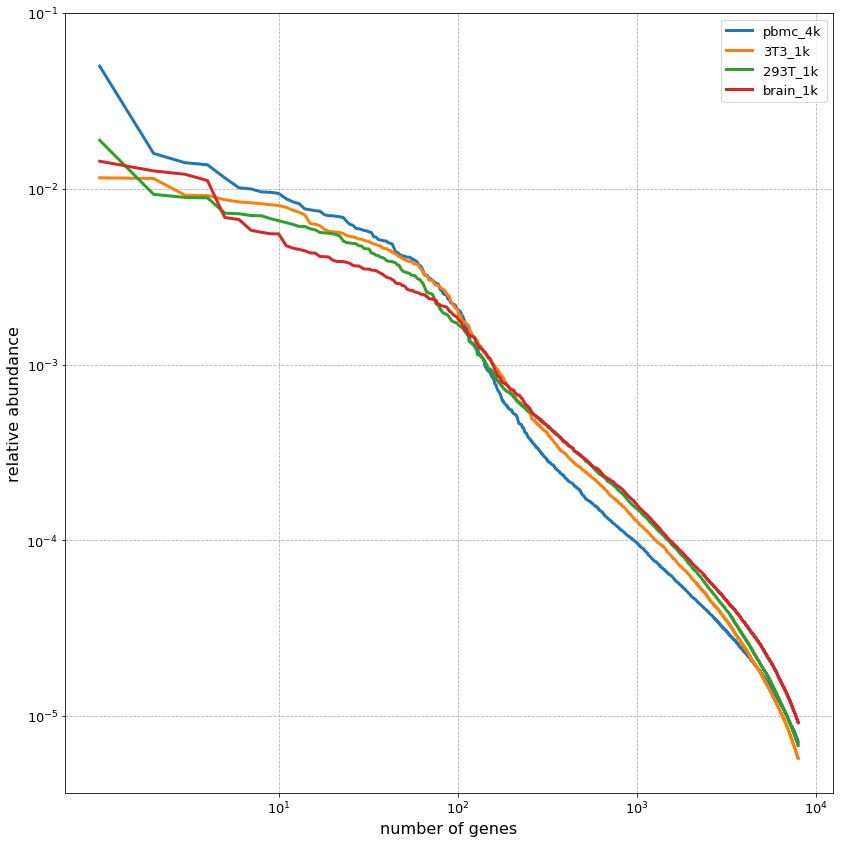

In [8]:
## relative abundance plot for brain 
# marker_gene_list_brain= ['Lhx6','Rpp25','Npy','Sst','Nxph1','Gria1','Gria2','Dlx2','Dlx1','Cldn1','Col4a2','Col4a1',\
#                   'Itm2a','Ccl4','Neurod1','Vtn','Igfbp4','Gadd45g','Hs6st2','Satb2','Jakmip1','Clmp','Nrp1',\
#                   'S100a10','Pcp4','Rnd2','Mef2c','Ptprd','Ly6h','Camk2b','Meg3','Tbr1','Reln',\
#                   'Cdk1','Cdkn2c','Pax6','Prox1']

plot_list = ['pbmc_4k','3T3_1k','293T_1k','brain_1k']
gene_star = 'S100a10'
data_ref = 'brain_1k'
plot_relative_abundance(plot_list,gene_param_dic,[],gene_star,data_ref,suffix='_alls',require_ref=False)

# B:  18874824.0
# p_star:  0.002210722600645177
# Nr_star 452


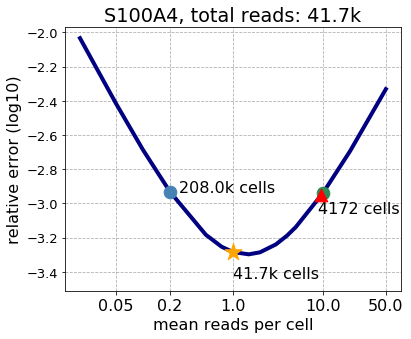

# n_reliable_genes 94
# n_top_gene 500


/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


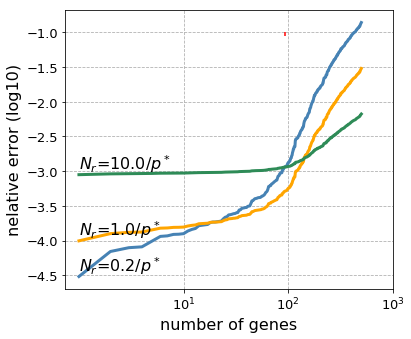

In [70]:
## relative abundance plot for pbmc 
marker_gene_list_pbmc = np.array(['CCR7', 'CD14', 'CD3D', 'CD3E', 'CD4', 'CD74', 'CD79A',
                                  'CD8A', 'CD8B', 'FCER1A', 'FCGR3A', 'FTH1', 'FTL',
                                  'GNLY', 'GZMK', 'HLA-A', 'HLA-C', 'ID3', 'IL7R',
                                  'LGALS3', 'LYZ', 'MS4A1', 'NKG7', 'PF4',
                                  'PPBP', 'S100A4', 'SELL'])

plot_list = ['pbmc_4k','pbmc_8k']
data_ref = 'pbmc_4k'
gene_star = 'S100A4'
plot_theoretical_curve(plot_list,gene_param_dic,marker_gene_list_pbmc,
                       gene_star,'pbmc_4k',suffix='_pbmc_4k_%s'%gene_star,
                       show_data_ref = False)

p_star 0.00013589530689133843 MS4A1
n_reliable_genes 675


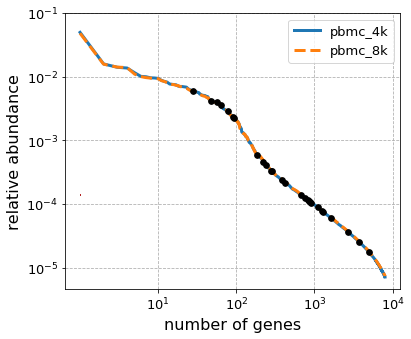

# B:  18874824.0
# p_star:  0.00013589530689133843
# Nr_star 7358


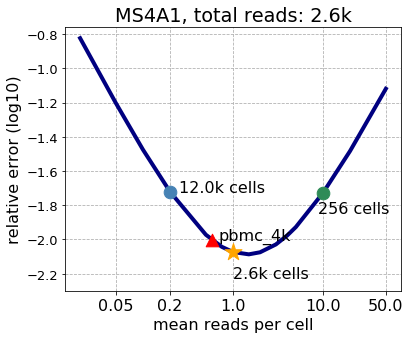

# n_reliable_genes 675
# n_top_gene 500


/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


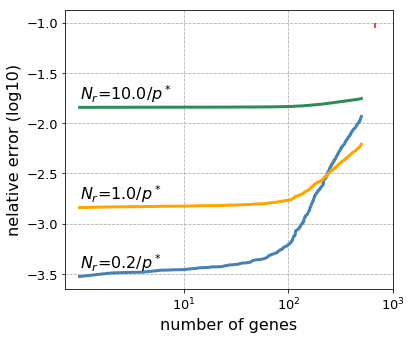

# B:  38879864.0
# p_star:  0.00014115275711869773
# Nr_star 7084


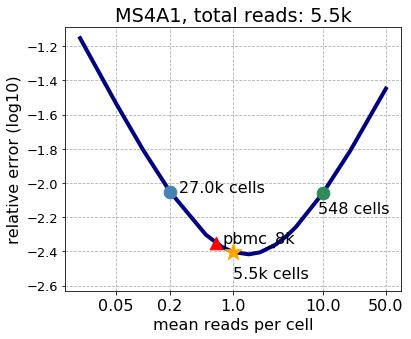

# n_reliable_genes 666
# n_top_gene 500


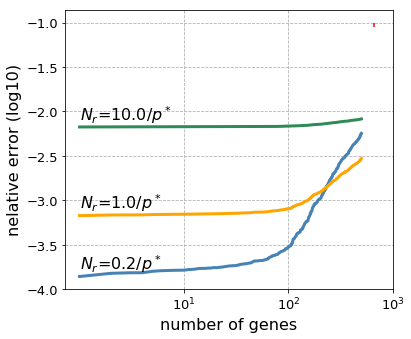

# B:  18874824.0
# p_star:  0.002210722600645177
# Nr_star 452


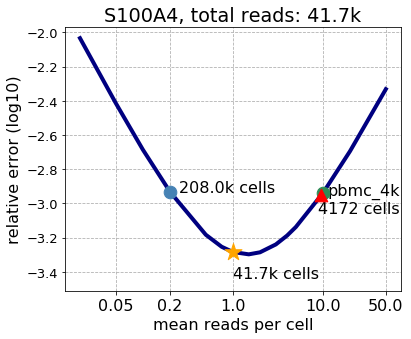

# n_reliable_genes 94
# n_top_gene 500


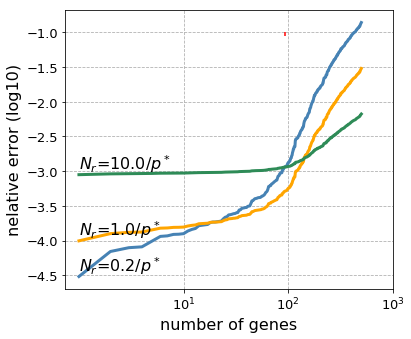

# B:  18874824.0
# p_star:  6.082175918567506e-05
# Nr_star 16441


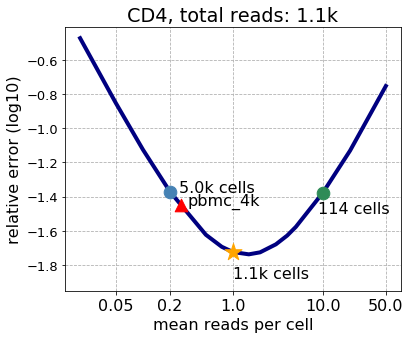

# n_reliable_genes 1607
# n_top_gene 500


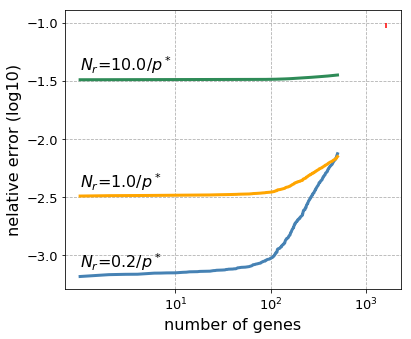

In [80]:
## relative abundance plot for pbmc 
marker_gene_list_pbmc = np.array(['CCR7', 'CD14', 'CD3D', 'CD3E', 'CD4', 'CD74', 'CD79A',
                                  'CD8A', 'CD8B', 'FCER1A', 'FCGR3A', 'FTH1', 'FTL',
                                  'GNLY', 'GZMK', 'HLA-A', 'HLA-C', 'ID3', 'IL7R',
                                  'LGALS3', 'LYZ', 'MS4A1', 'NKG7', 'PF4',
                                  'PPBP', 'S100A4', 'SELL'])

plot_list = ['pbmc_4k','pbmc_8k']
gene_star = 'MS4A1'
data_ref = 'pbmc_4k'
plot_relative_abundance(plot_list,gene_param_dic,marker_gene_list_pbmc,
                        gene_star,data_ref,suffix='_pbmc')
plot_theoretical_curve(plot_list,gene_param_dic,marker_gene_list_pbmc,
                       gene_star,'pbmc_4k',suffix='_pbmc_4k_%s'%gene_star)
plot_theoretical_curve(plot_list,gene_param_dic,marker_gene_list_pbmc,
                       gene_star,'pbmc_8k',suffix='_pbmc_8k_%s'%gene_star)

gene_star = 'S100A4'
plot_theoretical_curve(plot_list,gene_param_dic,marker_gene_list_pbmc,
                       gene_star,'pbmc_4k',suffix='_pbmc_4k_%s'%gene_star)

gene_star = 'CD4'
plot_theoretical_curve(plot_list,gene_param_dic,marker_gene_list_pbmc,
                       gene_star,'pbmc_4k',suffix='_pbmc_4k_%s'%gene_star)

# relative abundance plot for brain 
marker_gene_list_brain= ['Lhx6','Rpp25','Npy','Sst','Nxph1','Gria1','Gria2','Dlx2','Dlx1','Cldn1','Col4a2','Col4a1',\
                  'Itm2a','Ccl4','Neurod1','Vtn','Igfbp4','Gadd45g','Hs6st2','Satb2','Jakmip1','Clmp','Nrp1',\
                  'S100a10','Pcp4','Rnd2','Mef2c','Ptprd','Ly6h','Camk2b','Meg3','Tbr1','Reln',\
                  'Cdk1','Cdkn2c','Pax6','Prox1']

plot_list = ['brain_1k','brain_2k','brain_9k','brain_1.3m']
gene_star = 'S100a10'
data_ref = 'brain_1k'
plot_relative_abundance(plot_list,gene_param_dic,marker_gene_list_brain,gene_star,data_ref,suffix='_brain')
plot_theoretical_curve(plot_list,gene_param_dic,marker_gene_list_brain,gene_star,'brain_1.3m',suffix='_brain_1.3m')
plot_theoretical_curve(plot_list,gene_param_dic,marker_gene_list_brain,gene_star,'brain_9k',suffix='_brain_9k')
plot_theoretical_curve(plot_list,gene_param_dic,marker_gene_list_brain,gene_star,'brain_2k',suffix='_brain_2k')
plot_theoretical_curve(plot_list,gene_param_dic,marker_gene_list_brain,gene_star,'brain_1k',suffix='_brain_1k')

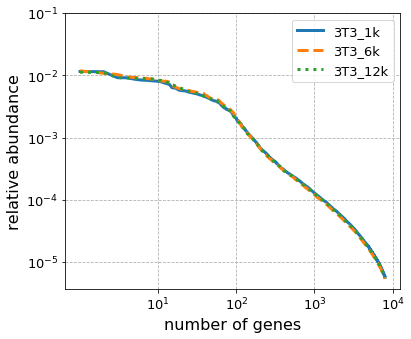

In [9]:
plot_list = ['3T3_1k','3T3_6k','3T3_12k']
gene_star = 'S100a10'
data_ref = 'brain_1k'
plot_relative_abundance(plot_list,gene_param_dic,[],gene_star,data_ref,suffix='_3T3',require_ref=False)

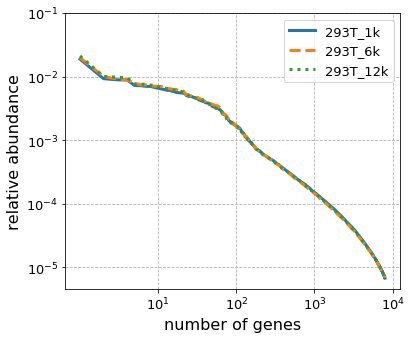

In [10]:
plot_list = ['293T_1k','293T_6k','293T_12k']
gene_star = 'S100a10'
data_ref = 'brain_1k'
plot_relative_abundance(plot_list,gene_param_dic,[],gene_star,data_ref,suffix='_293T',require_ref=False)